In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
ENTITY_TYPE = "skill_card"

DATA_DIR = f"./data/{ENTITY_TYPE}s"
EMBEDDING_DIM = 128
BATCH_SIZE = 64
EPOCHS = 10

MODEL_SAVE_PATH = f"./{ENTITY_TYPE}_model.pt"
ONNX_SAVE_PATH = f"./{ENTITY_TYPE}_model.onnx"

In [3]:
class SmallEmbeddingNet(nn.Module):
    def __init__(self, num_classes, embedding_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64 → 32
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32 → 16
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),  # → 1×1 output
        )
        self.embedding = nn.Linear(128, embedding_dim)
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        x = self.conv(x).view(x.size(0), -1)
        emb = self.embedding(x)
        out = self.classifier(emb)
        emb = F.normalize(emb, p=2, dim=1)
        return emb, out

In [4]:
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.uint8, scale=True),
        v2.RandomResize(16, 64, antialias=False),
        v2.Resize((64, 64)),
        v2.RandomResizedCrop(64, scale=(0.9, 1.0)),
        v2.ColorJitter(0.2, 0.2, 0.2),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

num_classes = len(dataset.classes)
print("Number of classes:", num_classes)

Number of classes: 2570


In [5]:
model = SmallEmbeddingNet(num_classes, EMBEDDING_DIM).to(device)

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
def train(model, dataloader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            embeddings, outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(dataloader):.4f}")
    return total_loss / len(dataloader)

In [190]:
# Run this until it's good
while True:
    loss = train(model, dataloader, optimizer, EPOCHS)
    if loss < 0.3:
        print("Training complete with acceptable loss.")
        break

Epoch [1/10], Loss: 0.5011
Epoch [2/10], Loss: 0.5270
Epoch [3/10], Loss: 0.5039
Epoch [4/10], Loss: 0.5008
Epoch [5/10], Loss: 0.4844
Epoch [6/10], Loss: 0.4776
Epoch [7/10], Loss: 0.4754
Epoch [8/10], Loss: 0.5501
Epoch [9/10], Loss: 0.5240
Epoch [10/10], Loss: 0.4526
Epoch [1/10], Loss: 0.4546
Epoch [2/10], Loss: 0.4814
Epoch [3/10], Loss: 0.4971
Epoch [4/10], Loss: 0.4902
Epoch [5/10], Loss: 0.4920
Epoch [6/10], Loss: 0.4650
Epoch [7/10], Loss: 0.5836
Epoch [8/10], Loss: 0.4923
Epoch [9/10], Loss: 0.4468
Epoch [10/10], Loss: 0.4130
Epoch [1/10], Loss: 0.4556
Epoch [2/10], Loss: 0.4701
Epoch [3/10], Loss: 0.4678
Epoch [4/10], Loss: 0.4584
Epoch [5/10], Loss: 0.4717
Epoch [6/10], Loss: 0.4487
Epoch [7/10], Loss: 0.4328
Epoch [8/10], Loss: 0.4980
Epoch [9/10], Loss: 0.4691
Epoch [10/10], Loss: 0.4485
Epoch [1/10], Loss: 0.4584
Epoch [2/10], Loss: 0.4557
Epoch [3/10], Loss: 0.3885
Epoch [4/10], Loss: 0.4154
Epoch [5/10], Loss: 0.4217
Epoch [6/10], Loss: 0.4383
Epoch [7/10], Loss: 0.464

In [191]:
for images, labels in dataloader:
    images = images.to(device)
    labels = labels.to(device)

    print("Labels:", labels)
    _, outputs = model(images)
    print("Predicted:", outputs.argmax(dim=1))
    break

Labels: tensor([ 626, 1541, 2402, 1622, 2426,  917, 2555, 1471, 1039,  404, 1710, 1660,
         496, 2354,  637, 1257, 1082, 1213, 2295, 2302,   71,  280,  211, 2112,
         497,   23,  813,  653,   33, 1474, 2057,  907, 1225,  116,  363,  922,
        1396, 1273, 1644, 1113,  347,  946,  908,  972,  132,  372, 1899,   24,
          27,   38, 1264,  410, 1900, 1842,  966,  992, 2204,  495, 2042, 1857,
        2067,  710, 2324,  344], device='cuda:0')
Predicted: tensor([ 626, 1541, 2402, 1622, 2426,  917, 2555, 1471, 1039,  404, 1710, 1660,
         496, 2354,  637, 1257, 1082, 1213, 2295, 2302,   71,  280,  211, 2112,
         497,   23,  813,  653,   33, 1474, 2057,  907, 1225,  116,  363,  922,
        1396, 1273, 1644, 1113,  348,  946,  908,  972,  132,  372, 1899,   24,
          27,   38, 1264,  410, 1900, 1842,  966,  992, 2204,  500, 2042, 1857,
        2067,  710, 2324,  348], device='cuda:0')


In [192]:
torch.save(model.state_dict(), MODEL_SAVE_PATH)

In [193]:
class EmbeddingOnly(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.conv = model.conv
        self.embedding = model.embedding

    def forward(self, x):
        x = self.conv(x).view(x.size(0), -1)
        return F.normalize(self.embedding(x), p=2, dim=1)

embedder = EmbeddingOnly(model).eval()
dummy_input = torch.randn(1, 3, 64, 64)
dummy_input = dummy_input.to(device)

torch.onnx.export(
    embedder,
    dummy_input,
    ONNX_SAVE_PATH,
    input_names=["input"],
    output_names=["embedding"],
    dynamic_axes={"input": {0: "batch_size"}},
    opset_version=11,
)

print(f"Exported ONNX model to: {ONNX_SAVE_PATH}")

Exported ONNX model to: ./skill_card_model.onnx


In [221]:
images, labels = next(iter(dataloader))
images = images.to(device)
_, logits = model(images)

print("Predicted:", logits[0].argmax().item())
print("True label:", labels[0].item())

Predicted: 938
True label: 938


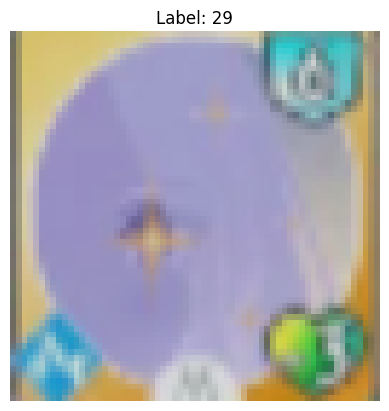

In [222]:
import matplotlib.pyplot as plt

img, label = dataset[37]
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()